# Inverse problem for the Poisson equation with unknown forcing field

- https://github.com/lululxvi/deepxde

## Problem setup

We will solve
$$
\nabla^2 u = q(x), \qquad x \in [-1, 1]
$$
with the Dirichlet boundary conditions
$$
u(-1) = 0, \qquad u(1) = 0
$$

The reference solution is $u(x) = \sin(\pi x), \qquad q(x) = -\pi^2 \sin(\pi x)$

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['DDE_BACKEND'] = 'pytorch'

In [ ]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [ ]:
def gen_traindata(num):
    xvals = np.linspace(-1, 1, num).reshape(-1, 1)
    uvals = np.sin(np.pi * xvals)
    return xvals, uvals

<matplotlib.collections.PathCollection>

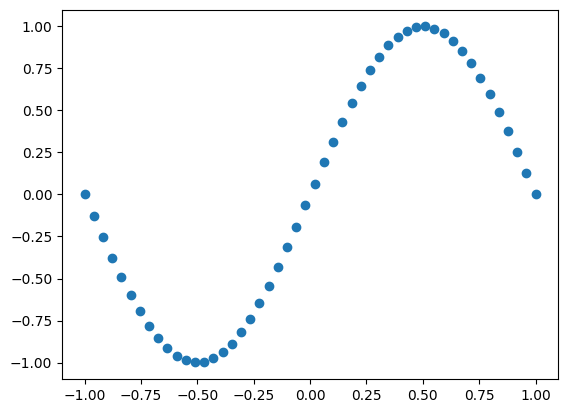

In [ ]:
plt.scatter(*gen_traindata(50))

In [ ]:
geom = dde.geometry.Interval(-1, 1)

In [ ]:
def pde(x, Y):
    u = Y[:, 0:1]
    q = Y[:, 1:2]

    du_xx = dde.grad.hessian(Y, x, component=0, i=0, j=0)
    return du_xx - q

In [ ]:
def boundary(x, on_boundary):
    return on_boundary

In [ ]:
def func_D(x):
    return 0

In [ ]:
bc_u = dde.icbc.DirichletBC(geom, func_D, boundary, component=0)

In [ ]:
ob_x, ob_u = gen_traindata(100)

In [ ]:
observe_u = dde.icbc.PointSetBC(ob_x, ob_u, component=0)

In [ ]:
data = dde.data.PDE(geom,
                    pde,
                    [bc_u, observe_u],
                    num_domain=200,
                    num_boundary=2,
                    anchors=ob_x,
                    num_test=1000)

We use two networks, one to train for `u(x)` and the other to train for `q(x)`. 

Here, we use two fully connected neural networks of depth 4 (i.e., 3 hidden layers) and width 20.

In [ ]:
layer_size = [1, [20, 20], [20, 20], [20, 20], 2]
activation = "tanh"
initializer = "Glorot uniform"

In [ ]:
net = dde.nn.PFNN(layer_size, activation, initializer)

In [ ]:
model = dde.Model(data, net)

In [ ]:
model.compile("adam", lr=0.0001, loss_weights=[1, 100, 1000])

Compiling model...
'compile' took 0.860297 s



In [ ]:
loss_history, train_state = model.train(iterations=20000)

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.85e-01, 1.00e+01, 7.69e+02]    [1.84e-01, 1.00e+01, 7.69e+02]    []  
1000      [8.13e-02, 4.63e+01, 1.57e+02]    [8.05e-02, 4.63e+01, 1.57e+02]    []  
2000      [2.66e+00, 1.75e+01, 4.20e+01]    [2.67e+00, 1.75e+01, 4.20e+01]    []  
3000      [1.33e+00, 2.56e+00, 5.62e+00]    [1.33e+00, 2.56e+00, 5.62e+00]    []  
4000      [2.90e-01, 2.00e-01, 4.49e-01]    [2.87e-01, 2.00e-01, 4.49e-01]    []  
5000      [5.74e-02, 8.01e-03, 2.15e-02]    [5.36e-02, 8.01e-03, 2.15e-02]    []  
6000      [1.18e-02, 3.92e-06, 2.91e-03]    [1.01e-02, 3.91e-06, 2.91e-03]    []  
7000      [3.79e-03, 3.04e-04, 2.56e-03]    [3.02e-03, 3.04e-04, 2.56e-03]    []  
8000      [2.12e-03, 2.67e-04, 1.63e-03]    [1.67e-03, 2.67e-04, 1.63e-03]    []  
9000      [1.32e-03, 1.31e-04, 8.86e-04]    [1.05e-03, 1.31e-04, 8.86e-04]    []  
10000     [7.25e-04, 6.17e-05, 4.27e-04]    [5.60e-04, 6.17e-

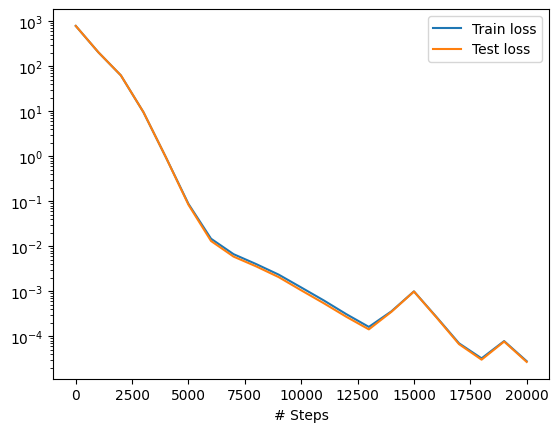

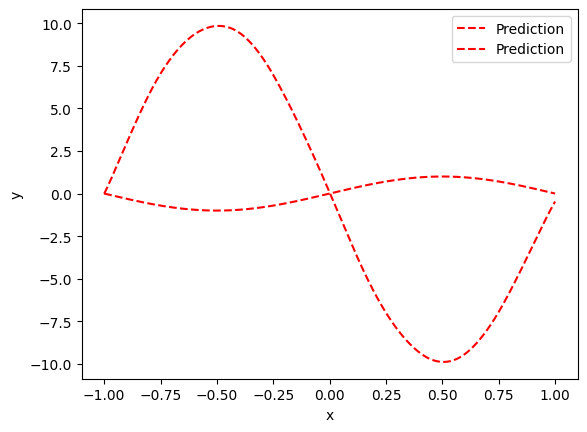

In [ ]:
dde.saveplot(loss_history, train_state, issave=False, isplot=True)

In [ ]:
x = geom.uniform_points(500)
Yhat = model.predict(x)
uhat, qhat = Yhat[:, 0:1], Yhat[:, 1:2] 

In [ ]:
utrue = np.sin(np.pi*x)
qtrue = -np.pi**2 * np.sin(np.pi*x)

In [ ]:
print(f"l2 relative error for u: {dde.metrics.l2_relative_error(utrue, uhat)}")

l2 relative error for u: 0.00020620026043616235


In [ ]:
print(f"l2 relative error for q: {dde.metrics.l2_relative_error(qtrue, qhat)}")

l2 relative error for q: 0.009778214618563652


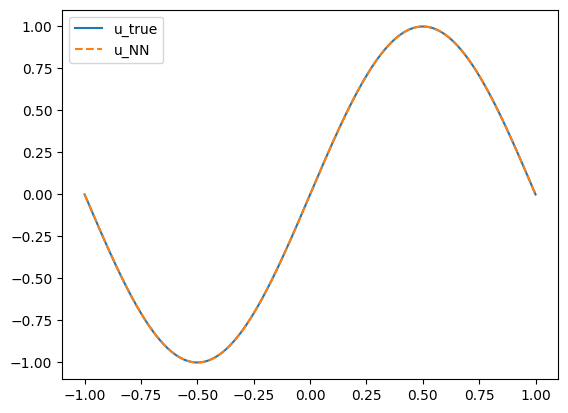

In [ ]:
plt.figure()
plt.plot(x, utrue, '-', label='u_true')
plt.plot(x, uhat, '--', label='u_NN')
plt.legend()
plt.show()

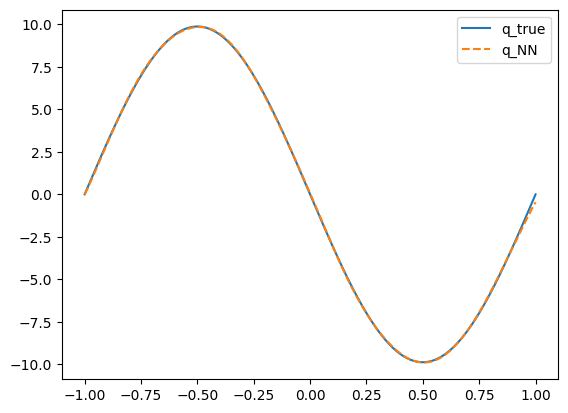

In [ ]:
plt.figure()
plt.plot(x, qtrue, '-', label='q_true')
plt.plot(x, qhat, '--', label='q_NN')
plt.legend()
plt.show()